The goal of this project is to train a model that will be able to tell us how much pure gold can be recovered from a sample of impure gold ore after an extraction process is performed.

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

gr_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gr_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gr_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [2]:
gr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [3]:
gr_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [4]:
gr_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [5]:
gr_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [6]:
gr_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [7]:
gr_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Dropping null values resulted on gr_full lost around 8000 rows. Will look into alternatives if relavent.

1.2

In [ ]:
rec_train = gr_train['rougher.output.recovery']
f_train = gr_train['rougher.input.feed_au']
c_train = gr_train['rougher.output.concentrate_au']
t_train = gr_train['rougher.output.tail_au']
output = c_train * (f_train - t_train)
input = f_train * (c_train - t_train)
my_rec = (output / input) * 100

In [9]:
print("My calculated recovery stats:")
print(my_rec.describe())
print(f"\nNumber of NaN values: {my_rec.isna().sum()}")
print(f"Number of infinite values: {np.isinf(my_rec).sum()}")

My calculated recovery stats:
count    1.457700e+04
mean              NaN
std               NaN
min              -inf
25%      7.965104e+01
50%      8.521533e+01
75%      9.019726e+01
max               inf
dtype: float64

Number of NaN values: 2283
Number of infinite values: 30


inf and -inf are likely caused by the null values from the origional data set

In [ ]:
# Create a mask for valid (non-NaN, non-infinite) values in both series
valid_mask = (~my_rec.isna()) & (~rec_train.isna()) & np.isfinite(
    my_rec) & np.isfinite(rec_train)

# Filter both series to only include valid values
my_rec_clean = my_rec[valid_mask]
rec_train_clean = rec_train[valid_mask]

# Now calculate MAE
mae = mean_absolute_error(rec_train_clean, my_rec_clean)
print(f"MAE: {mae}")

MAE: 9.303415616264301e-15


Basically Zero

1.3 Missing Features

In [11]:
train_columns = set(gr_train.columns)
test_columns = set(gr_test.columns)
missing_in_test = train_columns - test_columns
missing_in_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The data type that was taken out is mostly output data with a few calculations. The output were more than likely the targeted features.

1.4 Preprocessing

In [ ]:
def replace_nulls(df):
    # Calculate mean and median for each column
    summary = pd.DataFrame({
        'mean': df.mean(),
        'median': df.median()
    })

    # Calculate the difference between mean and median
    summary['difference'] = abs(summary['mean'] - summary['median'])

    # Decide whether to use mean or median based on the difference
    summary['replace_with'] = summary.apply(
        lambda row: 'median' if row['difference'] > 10 else 'mean', axis=1
    )

    # Replace null values in the DataFrame
    for column in df.columns:
        if column in summary.index:  # Check if the column exists in the summary
            if summary.loc[column, 'replace_with'] == 'median':
                df[column].fillna(summary.loc[column, 'median'], inplace=True)
            else:
                df[column].fillna(summary.loc[column, 'mean'], inplace=True)

    return df

In [ ]:
gr_train = gr_train.dropna(
    subset=['rougher.output.recovery', 'final.output.recovery'])
gr_full = gr_full.dropna(
    subset=['rougher.output.recovery', 'final.output.recovery'])

In [14]:
gr_train_clean = replace_nulls(gr_train)
gr_test_clean = replace_nulls(gr_test)
gr_full_clean = replace_nulls(gr_full)

In [15]:
gr_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14149 non-null  float64
 8   final.output.tail_sol                               14149 non-null  float64


In [16]:
duplicate_count_0 = gr_train_clean.duplicated().sum()
duplicate_count_1 = gr_test_clean.duplicated().sum()
duplicate_count_2 = gr_full_clean.duplicated().sum()
print(f"Number of duplicate rows in train: {duplicate_count_0}")
print(f"Number of duplicate rows in test: {duplicate_count_1}")
print(f"Number of duplicate rows in full: {duplicate_count_2}")

Number of duplicate rows in train: 0
Number of duplicate rows in test: 0
Number of duplicate rows in full: 0


2.1

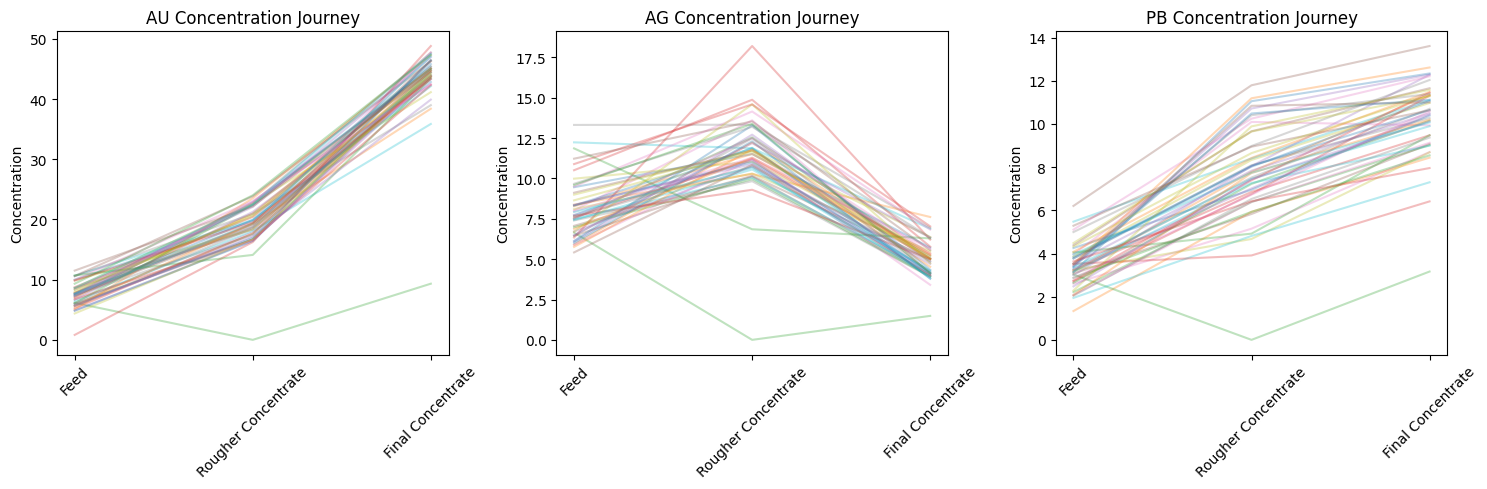

In [ ]:
# Sample a subset for clarity
sample_indices = gr_train_clean.sample(50).index

# Create subplots for each metal
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


metals = ['au', 'ag', 'pb']
stages = [
    ('rougher.input.feed', 'Feed'),
    ('rougher.output.concentrate', 'Rougher Concentrate'),
    ('final.output.concentrate', 'Final Concentrate')
]


for i, metal in enumerate(metals):
    for idx in sample_indices:
        concentrations = []
        for stage_prefix, stage_label in stages:
            col_name = f'{stage_prefix}_{metal}'
            if col_name in gr_train_clean.columns:
                concentrations.append(gr_train_clean.loc[idx, col_name])

        if len(concentrations) == len(stages):
            axes[i].plot(range(len(stages)), concentrations, alpha=0.3)

    axes[i].set_title(f'{metal.upper()} Concentration Journey')
    axes[i].set_xticks(range(len(stages)))
    axes[i].set_xticklabels([stage[1] for stage in stages], rotation=45)
    axes[i].set_ylabel('Concentration')

plt.tight_layout()
plt.show()

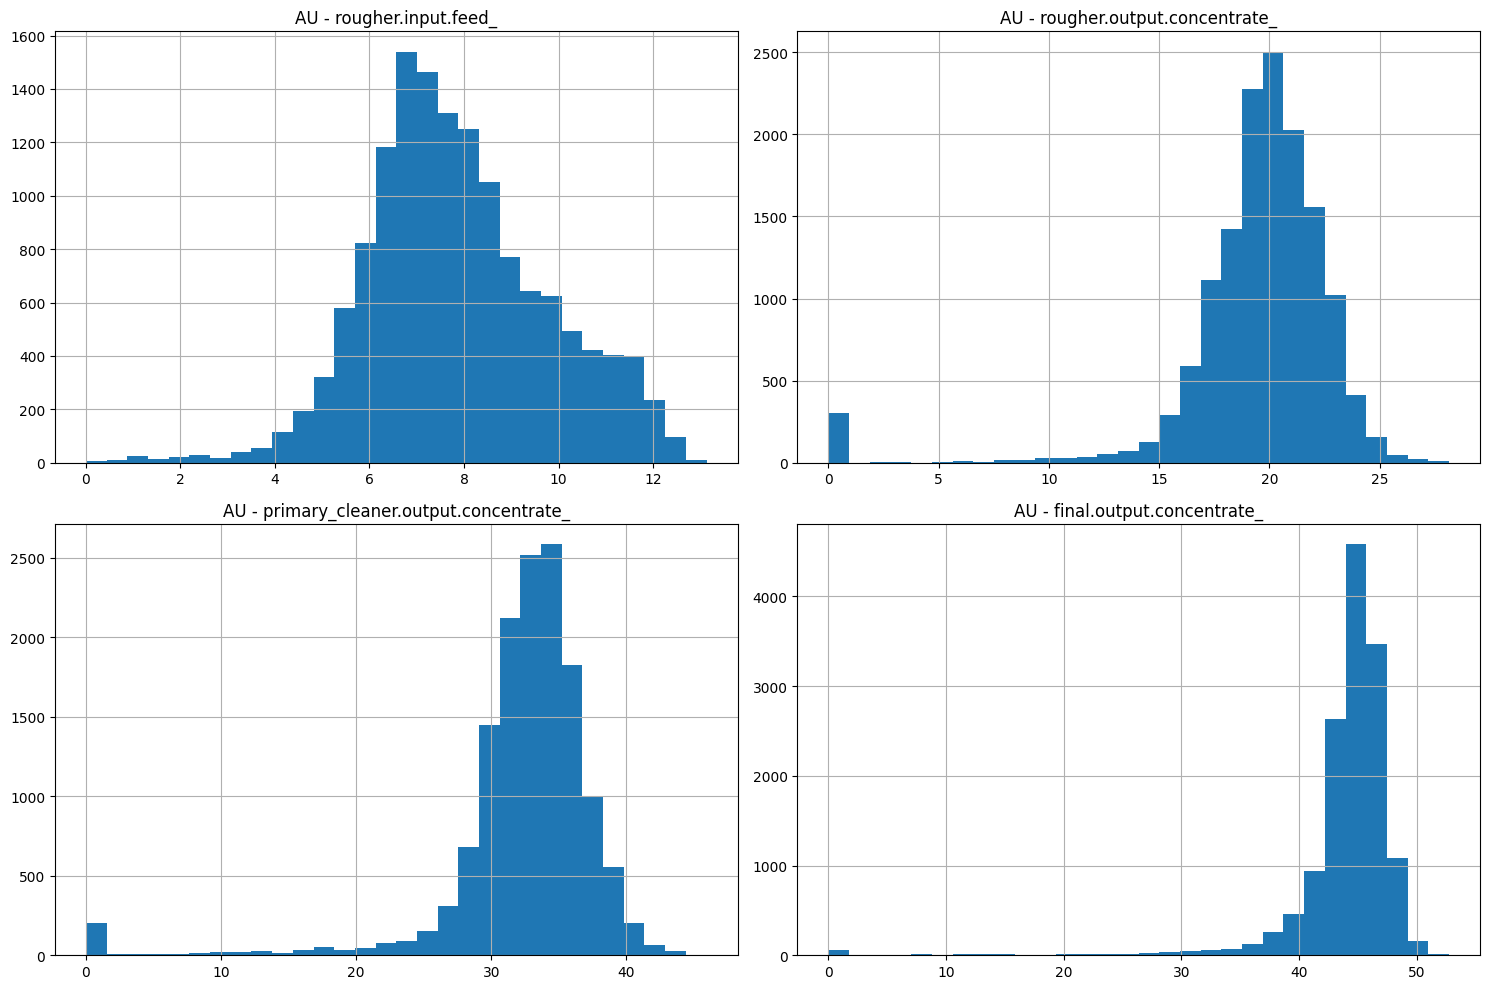

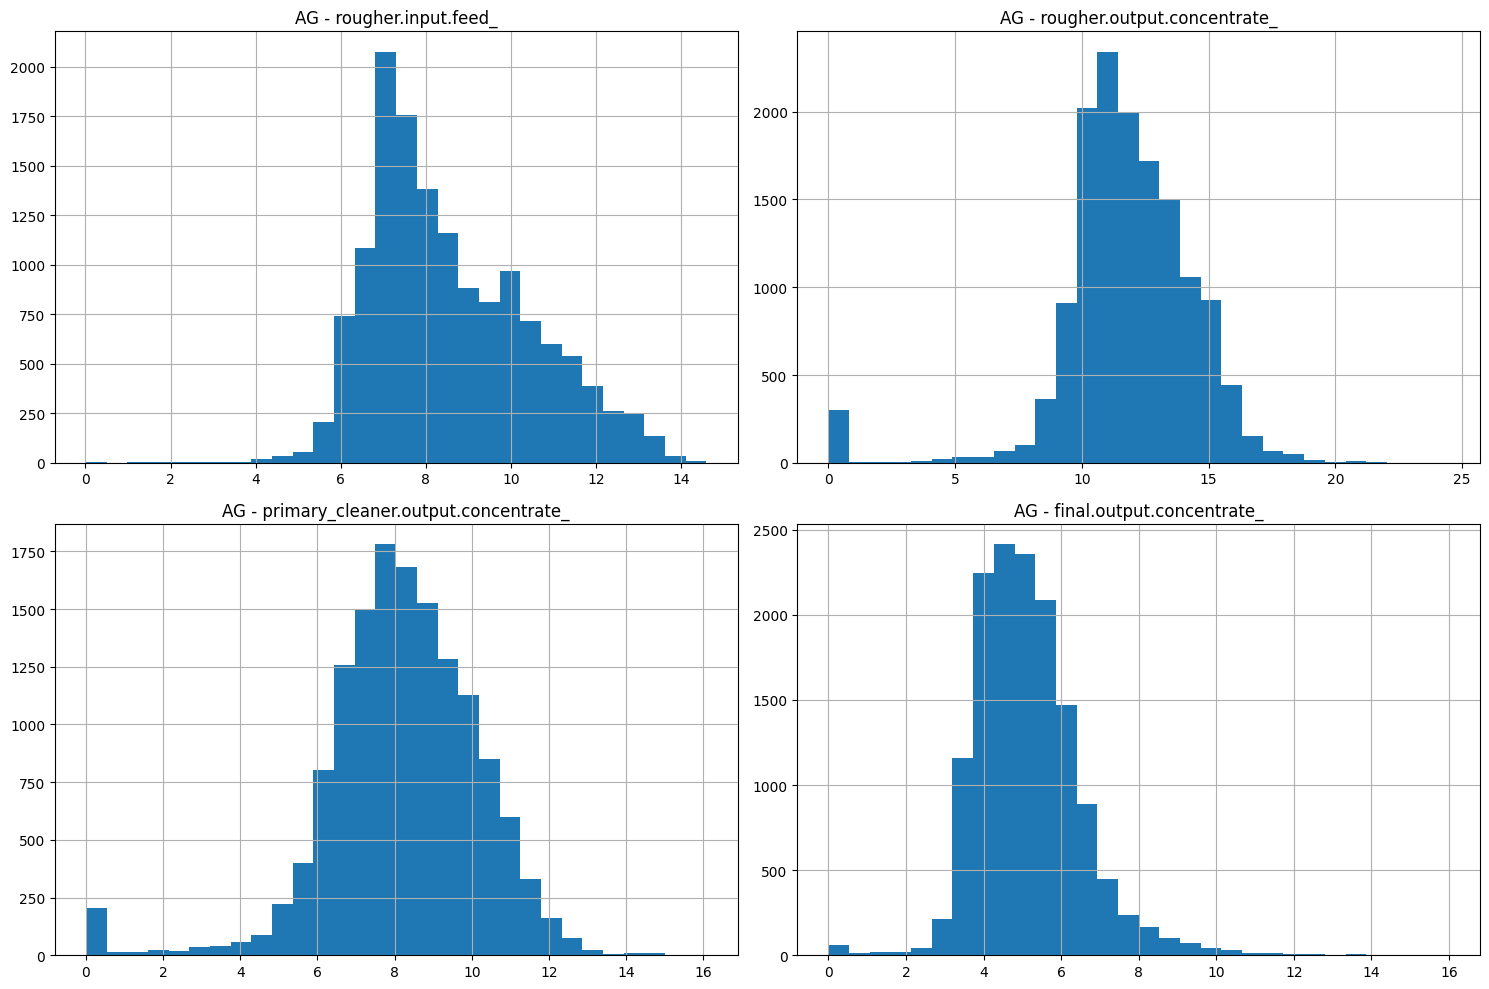

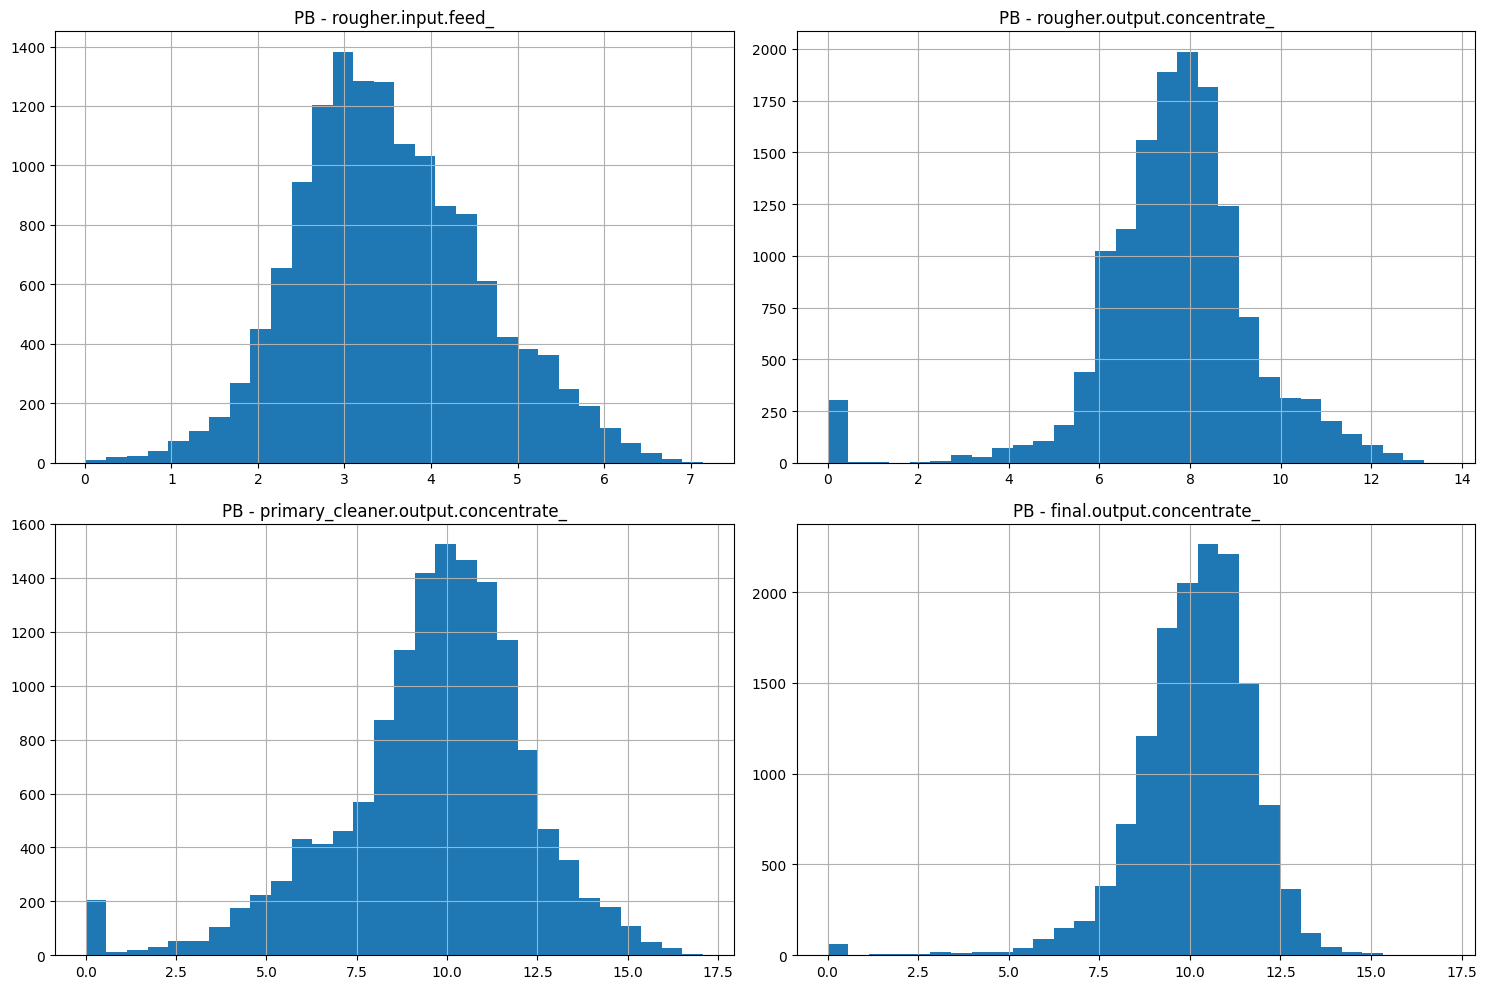

In [ ]:
# Example for one metal
metals = ['au', 'ag', 'pb']
stages = ['rougher.input.feed_', 'rougher.output.concentrate_',
          'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

for metal in metals:
    plt.figure(figsize=(15, 10))
    for i, stage in enumerate(stages):
        plt.subplot(2, 2, i+1)
        column_name = stage + metal
        gr_train_clean[column_name].hist(bins=30)
        plt.title(f'{metal.upper()} - {stage}')
    plt.tight_layout()
    plt.show()

Lead and Gold both end up with high concentrations by the end of the processing while silver decreases.

Each metal gernally follows a similar trend within its own catagory with one or two outleirs. There are also very small values where the values appear to be static in comparison to the other values.

2.2

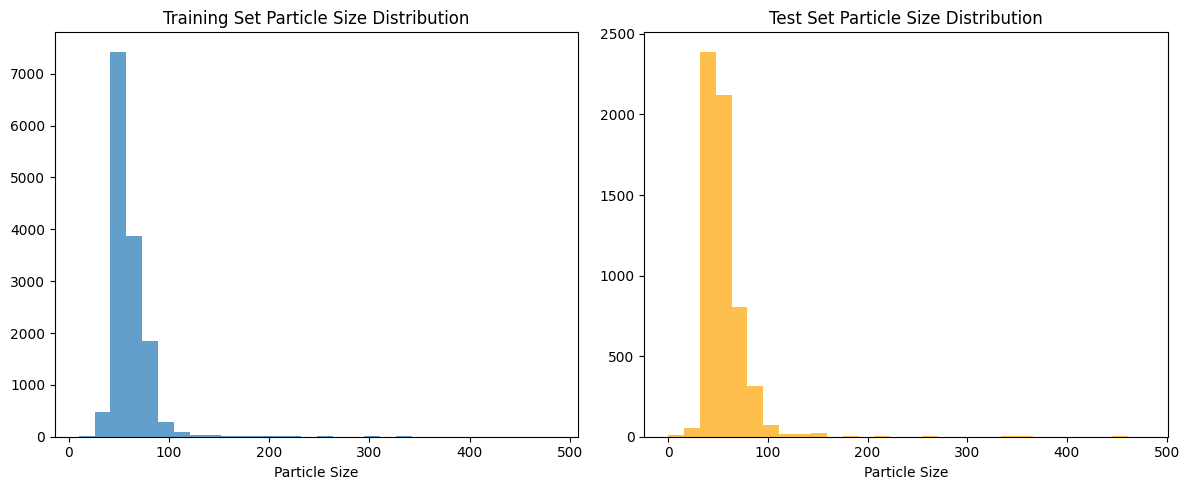

In [ ]:
# Get particle size from both datasets
train_particle_size = gr_train_clean['rougher.input.feed_size']
test_particle_size = gr_test_clean['rougher.input.feed_size']

# Plot histograms to compare
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_particle_size.dropna(), bins=30, alpha=0.7, label='Training')
plt.title('Training Set Particle Size Distribution')
plt.xlabel('Particle Size')


plt.subplot(1, 2, 2)
plt.hist(test_particle_size.dropna(), bins=30,
         alpha=0.7, label='Test', color='orange')
plt.title('Test Set Particle Size Distribution')
plt.xlabel('Particle Size')

plt.tight_layout()
plt.show()

The distributions do not appear to be dramatically different as they genreally fall into the same range.

2.3

Text(0.5, 0, 'Concentration Percent')

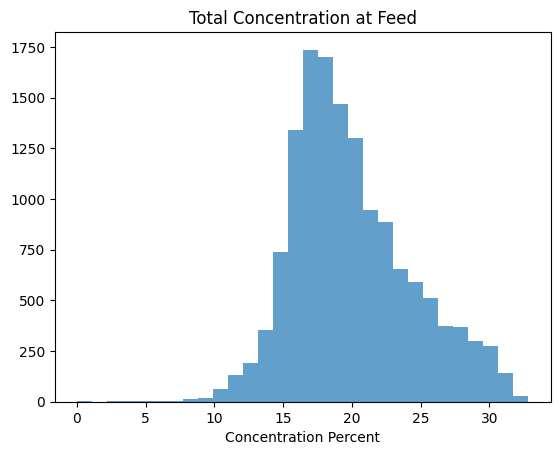

In [ ]:
total_feed = gr_train_clean['rougher.input.feed_au'] + \
    gr_train_clean['rougher.input.feed_ag'] + \
    gr_train_clean['rougher.input.feed_pb']
plt.hist(total_feed.dropna(), bins=30, alpha=0.7, label='feed')
plt.title('Total Concentration at Feed')
plt.xlabel('Concentration Percent')

Text(0.5, 0, 'Concentration Percent')

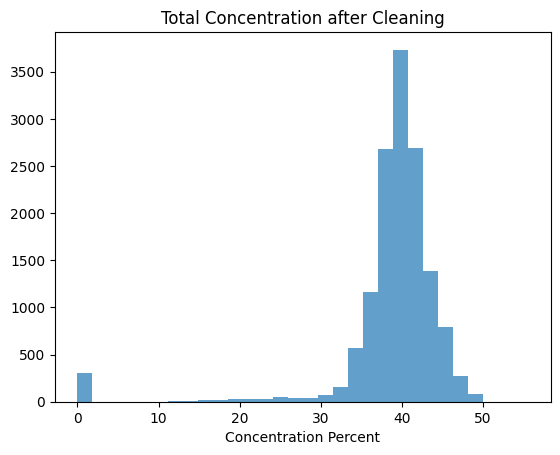

In [ ]:
total_rougher = gr_train_clean['rougher.output.concentrate_au'] + \
    gr_train_clean['rougher.output.concentrate_ag'] + \
    gr_train_clean['rougher.output.concentrate_pb']
plt.hist(total_rougher.dropna(), bins=30, alpha=0.7, label='feed')
plt.title('Total Concentration after Cleaning')
plt.xlabel('Concentration Percent')

Text(0.5, 0, 'Concentration Percent')

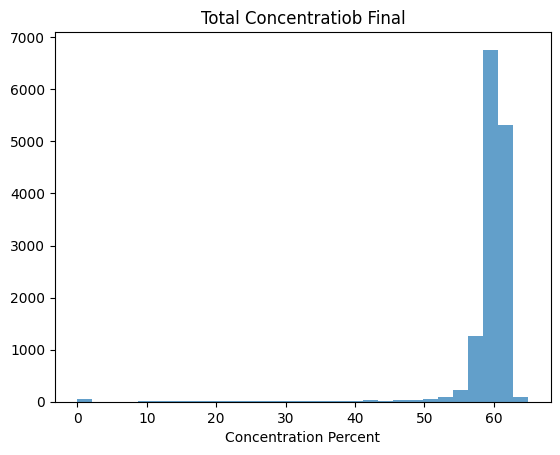

In [ ]:
total_final = gr_train_clean['final.output.concentrate_au'] + \
    gr_train_clean['final.output.concentrate_ag'] + \
    gr_train_clean['final.output.concentrate_pb']
plt.hist(total_final.dropna(), bins=30, alpha=0.7, label='feed')
plt.title('Total Concentratiob Final')
plt.xlabel('Concentration Percent')

In [ ]:
gr_train_clean = gr_train_clean[(gr_train_clean['rougher.input.feed_au'] > 1.0) &
                                (gr_train_clean['rougher.input.feed_ag'] > 1.0) &
                                (gr_train_clean['rougher.input.feed_pb'] > 1.0)]

In [ ]:
gr_train_clean = gr_train_clean[(gr_train_clean['rougher.output.concentrate_au'] > 1.0) &
                                (gr_train_clean['rougher.output.concentrate_ag'] > 1.0) &
                                (gr_train_clean['rougher.output.concentrate_pb'] > 1.0)]

In [ ]:
gr_train_clean = gr_train_clean[(gr_train_clean['final.output.concentrate_au'] > 1.0) &
                                (gr_train_clean['final.output.concentrate_ag'] > 1.0) &
                                (gr_train_clean['final.output.concentrate_pb'] > 1.0)]

In [ ]:
# sMAPE formula requires absolute value
def sMAPE(N, observed, prediction):
    smape = (1/N) * sum(abs(observed - prediction) /
                        ((abs(observed) + abs(prediction)) / 2)) * 100
    return smape

In [ ]:
columns_to_drop = ['date', 'rougher.output.recovery',
                   'final.output.recovery'] + list(missing_in_test)
features = gr_train_clean.drop(columns_to_drop, axis=1)
target = gr_train_clean[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [ ]:
# Base Line Model
model_rf = DummyRegressor()
model_rf.fit(features_train, target_train)
predictions_rf = model_rf.predict(features_valid)
predictions_valid_rf = predictions_rf  # Model's predictions
target_valid_saved_rf = target_valid  # Actual correct values
observations = len(predictions_valid_rf)
# For rougher recovery
rougher_target = target_valid_saved_rf['rougher.output.recovery']
rougher_predictions = predictions_valid_rf[:, 0]  # First column of predictions
rougher_smape = sMAPE(observations, rougher_target, rougher_predictions)

# For final recovery
final_target = target_valid_saved_rf['final.output.recovery']
final_predictions = predictions_valid_rf[:, 1]  # Second column of predictions
final_smape = sMAPE(observations, final_target, final_predictions)

# Weighted sMAPE
weighted_smape = (0.25 * rougher_smape) + (0.75 * final_smape)

print(f"Rougher Recovery sMAPE: {rougher_smape}")
print(f"Final Recovery sMAPE: {final_smape}")
print(f"Weighted Recovery sMAPE: {weighted_smape}")

Rougher Recovery sMAPE: 7.039712218772917
Final Recovery sMAPE: 10.173843858261016
Weighted Recovery sMAPE: 9.390310948388992


In [ ]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
predictions_valid_lr = predictions_lr  # Model's predictions
target_valid_saved_lr = target_valid  # Actual correct values
observations = len(predictions_valid_lr)
# For rougher recovery
rougher_target = target_valid_saved_lr['rougher.output.recovery']
rougher_predictions = predictions_valid_lr[:, 0]  # First column of predictions
rougher_smape = sMAPE(observations, rougher_target, rougher_predictions)

# For final recovery
final_target = target_valid_saved_lr['final.output.recovery']
final_predictions = predictions_valid_lr[:, 1]  # Second column of predictions
final_smape = sMAPE(observations, final_target, final_predictions)

# Weighted sMAPE
weighted_smape = (0.25 * rougher_smape) + (0.75 * final_smape)

print(f"Rougher Recovery sMAPE: {rougher_smape}")
print(f"Final Recovery sMAPE: {final_smape}")
print(f"Weighted Recovery sMAPE: {weighted_smape}")

Rougher Recovery sMAPE: 4.412689985830479
Final Recovery sMAPE: 7.927786906005132
Weighted Recovery sMAPE: 7.049012675961468


In [ ]:
model_rf = RandomForestRegressor()
model_rf.fit(features_train, target_train)
predictions_rf = model_rf.predict(features_valid)
predictions_valid_rf = predictions_rf  # Model's predictions
target_valid_saved_rf = target_valid  # Actual correct values
observations = len(predictions_valid_rf)
# For rougher recovery
rougher_target = target_valid_saved_rf['rougher.output.recovery']
rougher_predictions = predictions_valid_rf[:, 0]  # First column of predictions
rougher_smape = sMAPE(observations, rougher_target, rougher_predictions)

# For final recovery
final_target = target_valid_saved_rf['final.output.recovery']
final_predictions = predictions_valid_rf[:, 1]  # Second column of predictions
final_smape = sMAPE(observations, final_target, final_predictions)

# Weighted sMAPE
weighted_smape = (0.25 * rougher_smape) + (0.75 * final_smape)

print(f"Rougher Recovery sMAPE: {rougher_smape}")
print(f"Final Recovery sMAPE: {final_smape}")
print(f"Weighted Recovery sMAPE: {weighted_smape}")

Rougher Recovery sMAPE: 2.4924739288554743
Final Recovery sMAPE: 5.411378284740276
Weighted Recovery sMAPE: 4.681652195769075
